**THIS MODEL CAN BE TESTED IN THE FOLLOWING HUGGING FACE SPACE:**

https://huggingface.co/spaces/edogarci/cell_classification

# 1.0 IMPORTS

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.image import imread
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 2.0 Visualizing the Data

In [3]:
# Get current working directory,
# We will generate relative paths from here to acces training and testing images
cwd = Path(os.getcwd())

In [4]:
# path to all cell images
data_dir = (cwd/'cell_images')

In [5]:
os.listdir(data_dir)

['test', 'train']

In [6]:
# test and train subsets path
test_dir = (data_dir/'test')
train_dir = (data_dir/'train')

# test path
test_para = (test_dir/'parasitized')
test_uninf = (test_dir/'uninfected')

# training path
train_para = (train_dir/'parasitized')
train_uninf = (train_dir/'uninfected')

(103, 118, 3)
0.8627451
0.0


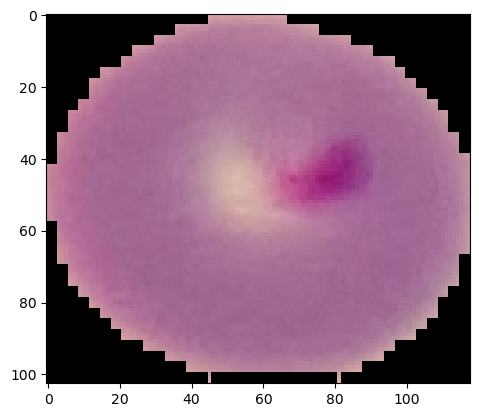

In [7]:
# Let's print any random image so we can check how the look and
# some properties like size, color channels and scale
any_img_path = os.listdir(train_para)[855]
any_img_path = (train_para/any_img_path)
any_img = plt.imread(any_img_path)
plt.imshow(any_img)
print(any_img.shape)
print(any_img.max())
print(any_img.min())

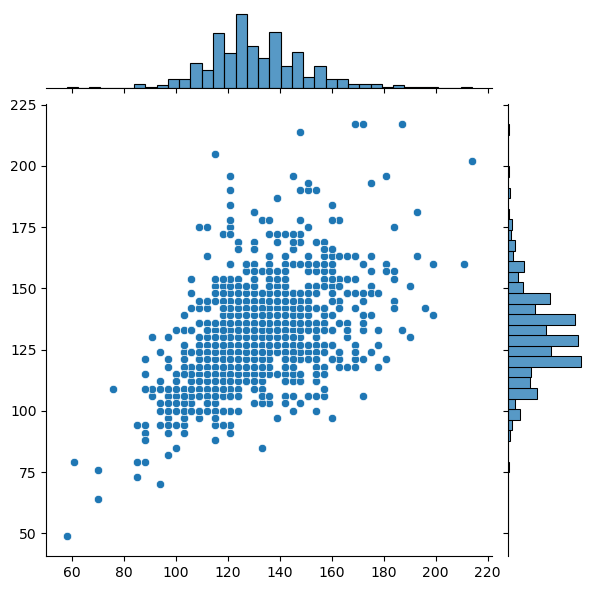

In [8]:
# Let's check if all images are the same size
dim1 = []
dim2 = []

for image_filename in os.listdir(test_uninf):
    img = plt.imread((test_uninf/image_filename))
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)
    
sns.jointplot(x=dim1,y=dim2)    

In [9]:
# Since not all of them are the same size, let's see what could be
# a "good for all" size
print(int(np.mean(dim1)))
print(int(np.mean(dim2)))

130
130


In [10]:
# Variable to set image size (used in following lines)
image_shape = (int(np.mean(dim1)), int(np.mean(dim2)), 3)
image_shape

(130, 130, 3)

# 3.0 Preparing the Data for the model

In [12]:
#defining the image data generator
image_gen = ImageDataGenerator(rotation_range=20, # randomly rotate image, max 20
                               width_shift_range=0.10, # shift width, max 5%
                               height_shift_range=0.10, # shift height, max 5%
#                                rescale=1/255, # rescale image values, not necessary since it's alreay scaled
                               shear_range=0.1, # cut part of the image, max 10%
                               zoom_range=0.1, # zoom image, max 10%
                               horizontal_flip=True, # randomly flip horizontally
                               fill_mode='constant', # fill missing pixels with 'CVAL'
                               cval=0) # black

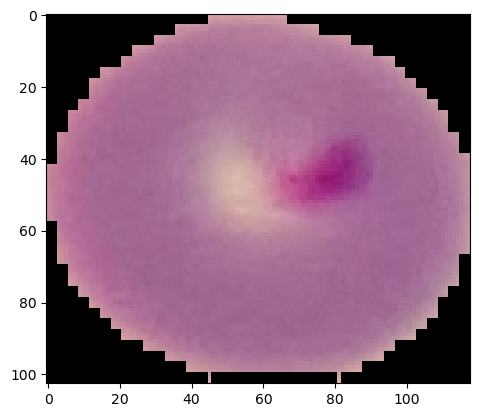

In [13]:
# comparing original image vs. data augmented generated image
plt.imshow(any_img)

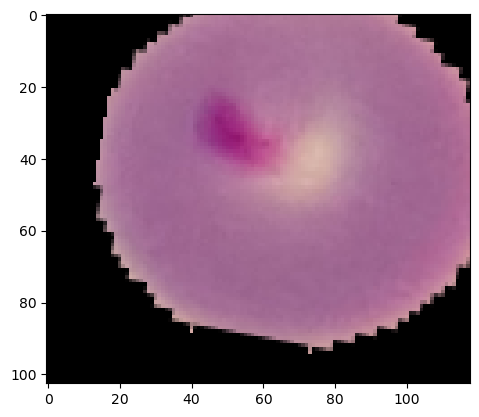

In [14]:
plt.imshow(image_gen.random_transform(any_img))

# 4.0 Creating the Model

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [16]:
model = Sequential()

#convolutional + max pooling layers
model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

#flattening data
model.add(Flatten())

model.add(Dense(128, activation='relu'))

# Dropout to reduce overfitting
model.add(Dropout(0.5))

# output layer,
# using sigmoid since it is a binary classification problem
model.add(Dense(1, activation='sigmoid'))

# compiling model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

In [19]:
# adding early stopper to optimize training epochs
early_stop = EarlyStopping(monitor='val_loss',patience=2)

# 5.0 Training the Model

In [20]:
# set batch size
batch_size=8

In [21]:
# defining image generator for training
train_image_gen = image_gen.flow_from_directory(train_dir,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 24958 images belonging to 2 classes.


In [22]:
# defining image generator for testing
test_image_gen = image_gen.flow_from_directory(test_dir,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 2600 images belonging to 2 classes.


In [23]:
# check what indices has been assigned to each class
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [24]:
# train the model
results = model.fit_generator(train_image_gen,
                              epochs=20,
                              validation_data=test_image_gen,
                              callbacks=[early_stop])

Epoch 1/20


C:\Users\Edorta\AppData\Local\Temp\ipykernel_13896\2769811360.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  results = model.fit_generator(train_image_gen,


3120/3120 [==============================] - 408s 131ms/step - loss: 0.4358 - accuracy: 0.7906 - val_loss: 0.1928 - val_accuracy: 0.9369
Epoch 2/20
3120/3120 [==============================] - 267s 85ms/step - loss: 0.1787 - accuracy: 0.9429 - val_loss: 0.1715 - val_accuracy: 0.9458
Epoch 3/20
3120/3120 [==============================] - 255s 82ms/step - loss: 0.1676 - accuracy: 0.9481 - val_loss: 0.1807 - val_accuracy: 0.9427
Epoch 4/20
3120/3120 [==============================] - 269s 86ms/step - loss: 0.1700 - accuracy: 0.9466 - val_loss: 0.1611 - val_accuracy: 0.9438
Epoch 5/20
3120/3120 [==============================] - 256s 82ms/step - loss: 0.1624 - accuracy: 0.9489 - val_loss: 0.1779 - val_accuracy: 0.9408
Epoch 6/20
3120/3120 [==============================] - 256s 82ms/step - loss: 0.1650 - accuracy: 0.9473 - val_loss: 0.1836 - val_accuracy: 0.9408


## 5.1 Analizing metrics

In [32]:
metrics = pd.DataFrame(model.history.history)

<Axes: >

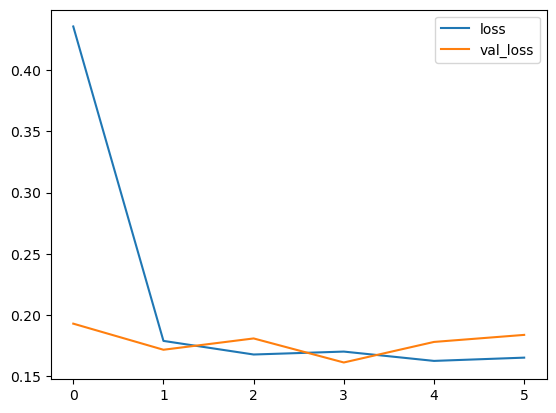

In [40]:
# plotting loss
metrics[['loss', 'val_loss']].plot()

<Axes: >

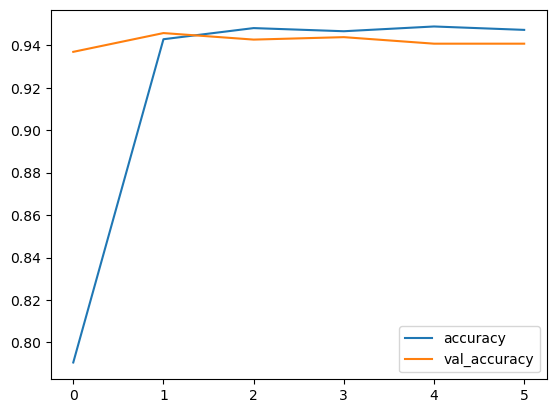

In [41]:
# plotting accuracy
metrics[['accuracy', 'val_accuracy']].plot()

# 6.0 Test predictions

In [65]:
from PIL import Image

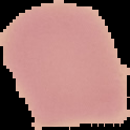

In [70]:
# preprocessing random testing image to make a prediction
any_img_test_path = os.listdir(test_uninf)[42]
any_img_test_path = (test_uninf/any_img_test_path) #preparing path
any_img_test = Image.open(any_img_test_path) #opening image
any_img_test = any_img_test.resize((130,130)) #resizing
display(any_img_test)

In [73]:
# reshaping array for test prediction
any_img_test_array = np.array(any_img_test)
np.array([any_img_test_array]).shape

(1, 130, 130, 3)

In [74]:
# make prediction
prediction = model.predict(np.array([any_img_test_array]))

1/1 [==============================] - 0s 111ms/step


In [75]:
#predicted value
prediction

array([[1.]], dtype=float32)

In [76]:
test_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [77]:
any_img_test_path

WindowsPath('C:/Users/Edorta/Desktop/cell_images/test/uninfected/C107P68ThinF_IMG_20150924_221909_cell_83.png')

# 7.0 SAVING MODEL

In [78]:
#save model to be used in GRADIO interface
model.save('call_classifier_model.h5')

**THIS MODEL CAN BE TESTED IN THE FOLLOWING HUGGING FACE SPACE:**

https://huggingface.co/spaces/edogarci/cell_classification